# Imports

In [1]:
import os
import openai
import random
import urllib.request
import ipywidgets as widgets
import matplotlib.pyplot as plt
import imgaug as ia
import imageio
import shutil
import yaml
import fnmatch
import numpy as np
from math import pi, cos, sin
from imgaug import augmenters as iaa
from PIL import Image, ImageDraw, ImageFilter

# Load your API key from an environment variable or secret management service
openai.api_key = os.getenv("OPENAI_API_KEY")

# Constants

In [2]:
BACKGROUND_PATH = "backgrounds/"
IMAGE_PATH = "dataset/train/images"
LABEL_PATH = "dataset/train/labels"
TRAFFIC_SIGN_PATH = "traffic_signs_only"
TEMP_PATH = "temp"
IMG_SIZE = 512

# Generate Images

### Preparation

In [3]:
# first check that the classes in the data.yaml file are the same as the ones in the traffic_signs_only folder
with open("data.yaml", 'r') as stream:
    data = yaml.safe_load(stream)
    classes = data['names']

# check that the classes in the traffic_signs_only folder are the same as the ones in the data.yaml file
for file in os.listdir(TRAFFIC_SIGN_PATH):
    # strip the .png extension
    file = file.split(".")[0]
    if file not in classes:
        print("The class {} is not in the data.yaml file".format(file))

# check the other way around
for class_name in classes:
    # add the .png extension
    class_name = class_name + ".png"
    if class_name not in os.listdir(TRAFFIC_SIGN_PATH):
        print("The class {} is not in the traffic_signs_only folder".format(class_name))

The class Firefox Installer is not in the data.yaml file
The class no overtaking -trucks-.png is not in the traffic_signs_only folder
The class restriction ends (overtaking).png is not in the traffic_signs_only folder
The class restriction ends -overtaking -trucks--.png is not in the traffic_signs_only folder


In [4]:
# create dataset directory if it doesn't exist
if not os.path.exists(IMAGE_PATH):
    os.makedirs(IMAGE_PATH)
if not os.path.exists(LABEL_PATH):
    os.makedirs(LABEL_PATH)
if not os.path.exists(BACKGROUND_PATH):
    os.makedirs(BACKGROUND_PATH)

### Generate Background Images

In [5]:
# create a slider for the number of background images to generate
background_slider = widgets.IntSlider(min=0, max=1000, step=1, value=10, description='Number of images to generate:')
display(background_slider)

IntSlider(value=10, description='Number of images to generate:', max=1000)

In [6]:
# create selection for whether to generate background images because this is time consuming and should only be done if necessary
OPTION1 = "Generate background images"
OPTION2 = "Use existing background images"
select = widgets.Select(options=[OPTION1, OPTION2], value=OPTION2, rows=2, description='Select:', disabled=False)
display(select)

Select(description='Select:', index=1, options=('Generate background images', 'Use existing background images'…

In [7]:
if select.value == OPTION1:
    for i in range(background_slider.value):
        # a list of different types of roads in different environments 
        road_types = ["highway", "highway with traffic", "highway with traffic andpedestrians", "highway with traffic and pedestrians and construction", "highway withtraffic and pedestrians and construction and road works", "autobahn", "street", "street with traffic", "street with pedestrians"]
        # a list of different day and night time
        daytime = ["during daytime", "during nighttime", "during sunrise", "during sunset","during dusk", "during dawn"]
        # use DALL-E to generate a background image environment that usually contain trafficsigns
        random_road_type = f"A photograph of a {road_types[random.randint(0, len(road_types) -1)]} {daytime[random.randint(0, len(daytime) - 1)]} from drivers perspective."
        response = openai.Image.create(
            prompt=random_road_type,
            n=1,
            size=f"{IMG_SIZE}x{IMG_SIZE}",
        )
        image_url = response["data"][0]["url"]
        # get amount of images in background directory
        amount_background_images = len(os.listdir(BACKGROUND_PATH))
        # download the image to and save it to the background directory
        urllib.request.urlretrieve(image_url, f"{BACKGROUND_PATH}/background{amount_background_images}.png")

### Add Trafic Signs

In [8]:
# create a slider for the number of images to generate
slider = widgets.IntSlider(min=0, max=1000, step=1, value=10, description='Number of images to generate:')
display(slider)

IntSlider(value=10, description='Number of images to generate:', max=1000)

Added fog to image.


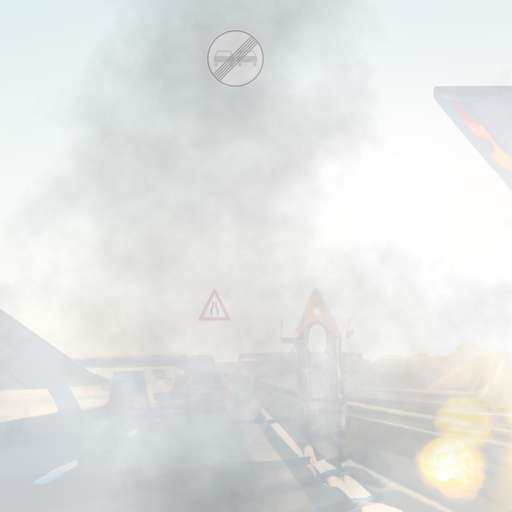

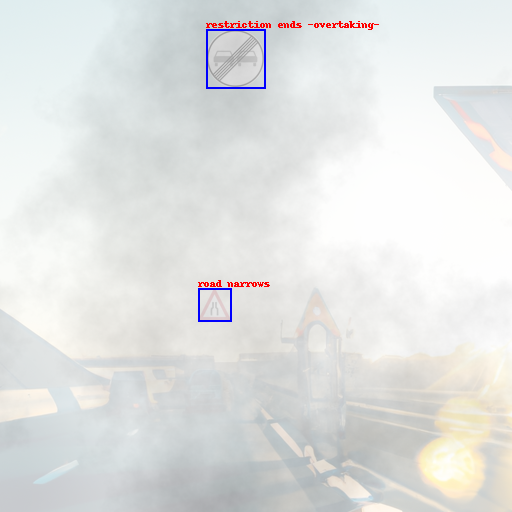

Added rain to image.


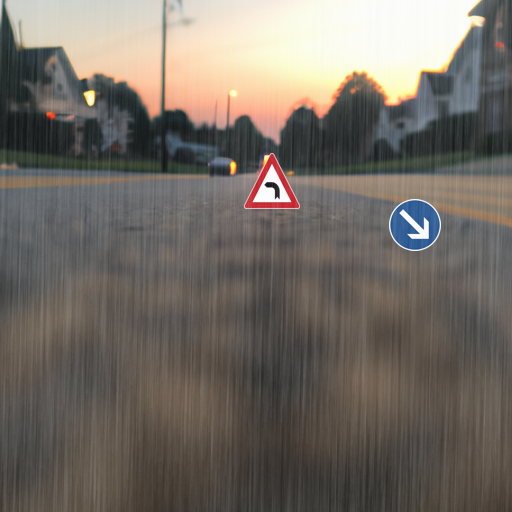

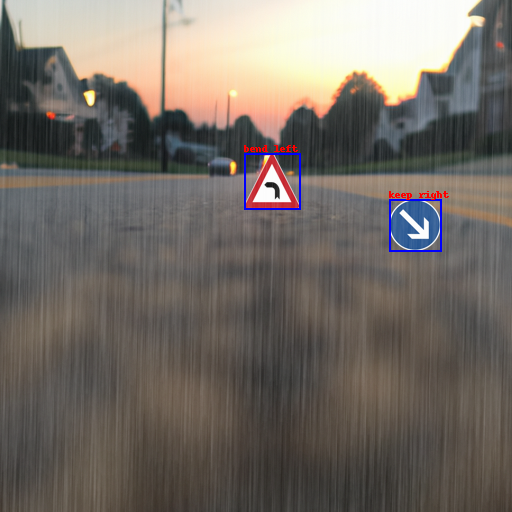

Added fog to image.


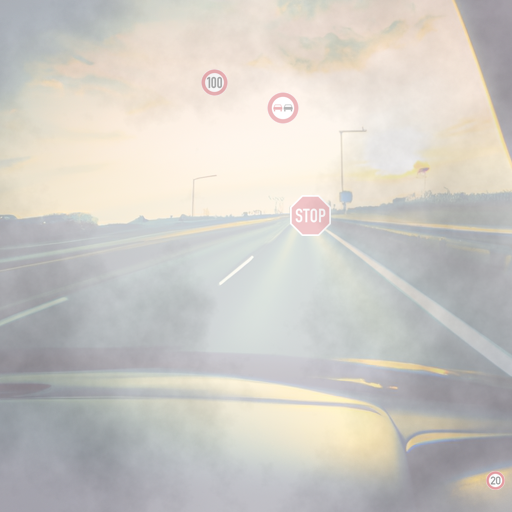

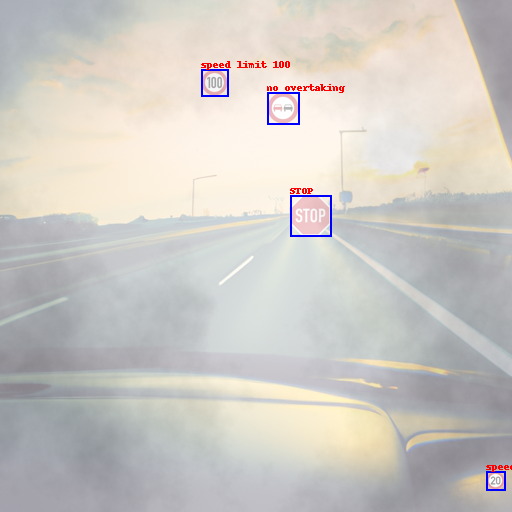

In [19]:
# create for loop for the number of images to generate
for i in range(slider.value):
    # create a dictionary to save the positions of the traffic sign images on the background image
    traffic_sign_positions = {}
    # remove temporary directory
    if os.path.exists(TEMP_PATH):
        shutil.rmtree(TEMP_PATH)
    
    # check if i is higher than the amount of images in the background directory
    if i >= len(os.listdir(BACKGROUND_PATH)):
        # choose a random image from the background directory
        pil_image = Image.open(f"{BACKGROUND_PATH}/background_{random.randint(0, len(os.listdir(BACKGROUND_PATH)) - 1)}.png")
    else:
        pil_image = Image.open(f"{BACKGROUND_PATH}/background_{i}.png")
    # get 1-4 random images from the traffic sings only directory
    random_images = random.sample(os.listdir(TRAFFIC_SIGN_PATH), random.randint(1, 4))
    # create temporary directory for the traffic sign images
    if not os.path.exists(TEMP_PATH):
        os.mkdir(TEMP_PATH)

    # copy images to temp directory
    for image in random_images:
        shutil.copy(f"{TRAFFIC_SIGN_PATH}/{image}", TEMP_PATH)

    images_aug = {}
    # create for loop to resize the traffic sign images
    for image in os.listdir(TEMP_PATH):
        image_transform = Image.open(f"{TEMP_PATH}/{image}")
        # define a random size for the traffic sign images
        size = random.randint(15,60)
        # resize the traffic sign image
        image_transform = image_transform.resize((size, size))         
        images_aug[image] = image_transform
    
    # create for loop to paste the traffic sign images on the background image        
    for name, image in images_aug.items():
        # define a random position for the traffic sign image on the background image to be placed    
        random_position = (random.randint(20, 492), random.randint(20, 492))              
        # paste the traffic sign image on the background image
        pil_image.paste(image, random_position, mask=image)
        # create a object to store position and size of the traffic sign image
        size_and_position = {}
        size_and_position["size"] = (image.size[0], image.size[1])
        size_and_position["position"] = random_position
        # save the position of the traffic sign image
        traffic_sign_positions[name] = size_and_position
    
    # get all strings in list to one string without png extension
    # remove .png extension for each string in list
    random_images = [image.split(".")[0] for image in random_images]
    image_save_name = "_".join(random_images)
    # check if image name already exists
    filenames = os.listdir(IMAGE_PATH)
    # define matching pattern for image name
    pattern = f"{image_save_name}_*.png"
    # Use a list comprehension to count the number of filenames that match the search pattern
    match_count = sum([1 for filename in filenames if fnmatch.fnmatch(filename, pattern)])
    if match_count > 0:
        # if image name already exists, add a number to the end of the image name
        image_save_name = f"{image_save_name}_{match_count + 1}"
    else:
        # if image name does not exist, create the image name
        image_save_name = f"{image_save_name}_0"

    # choose random weather to add to the image
    weather = ["rain", "snow", "fog", "none"]
    random_weather = f"{weather[random.randint(0, len(weather) - 1)]}"
    # transform image to numpy array
    image = np.array(pil_image)
    # add weather to image
    if random_weather == "rain":
        print("Added rain to image.")
        aug = iaa.Rain(speed=(0.1, 0.3), drop_size=(0.1, 0.2))
        image = aug(image=image)
    elif random_weather == "snow":
        print("Added snow to image.")
        aug = iaa.Snowflakes(flake_size=(0.1, 0.3), speed=(0.01, 0.05))
        image = aug(image=image)
    elif random_weather == "fog":
        print("Added fog to image.")
        aug = iaa.Fog()
        image = aug(image=image)
    elif random_weather == "none":
        pass

    # convert image back to PIL image
    pil_image = Image.fromarray(image)

    # save the image to the dataset directory
    pil_image.save(f"{IMAGE_PATH}/{image_save_name}.png")
    # display the image
    #print("Generated image with traffic signs:")
    display(pil_image) 
    
    # create for loop to draw boxes around the traffic sign images
    for image_name, pos_size in traffic_sign_positions.items():
        with Image.open(f"{TEMP_PATH}/{image_name}") as image:
            # get the width and height of the image
            width, height = pos_size["size"]
            # get the position of the image
            x_pos = pos_size["position"][0]
            y_pos = pos_size["position"][1]
            # draw boxes around the traffic sign images
            draw = ImageDraw.Draw(pil_image)
            # draw a rectangle around the traffic sign image
            draw.rectangle([x_pos, y_pos, x_pos + width, y_pos + height], outline="blue", width=2)
            # extract the class name from the image name
            class_name = image_name.split(".")[0]
            # draw the class name above the traffic sign image
            draw.text((x_pos, y_pos - 10), class_name, fill="red")
            # get class name index
            class_id = classes.index(class_name)
            # convert x_pos and y_pos to center coordinates
            x_pos = x_pos + (width / 2)
            y_pos = y_pos + (height / 2)
            # convert x_pos and y_pos to relative coordinates
            x_pos = x_pos / IMG_SIZE
            y_pos = y_pos / IMG_SIZE
            # convert width and height to relative coordinates
            width = width / IMG_SIZE
            height = height / IMG_SIZE
            # save labels in yolov7 format
            with open(f"{LABEL_PATH}/{image_save_name}.txt", "a") as f:
                f.write(f"{class_id} {x_pos} {y_pos} {width} {height}\n")
                
    # show the image with the boxes
    #print("Generated image with bounding boxes:")
    display(pil_image)
    # remove temporary directory
    if os.path.exists(TEMP_PATH):
        shutil.rmtree(TEMP_PATH)

In [28]:
# create a slider for the validation split percentage
val_slider = widgets.IntSlider(min=0, max=25, step=1, value=10, description='Percentage of images to use for validation dataset:')
display(val_slider)

IntSlider(value=10, description='Percentage of images to use for validation dataset:', max=25)

In [22]:
# Set the percentage of files to copy
percentage = val_slider.value

# Set the source and destination directories
src_dir_images = IMAGE_PATH
dst_dir_images = 'dataset/valid/images'
src_dir_labels = LABEL_PATH
dst_dir_labels = 'dataset/valid/labels'

# Create the new destination directories
if not os.path.exists(dst_dir_images):
    os.makedirs(dst_dir_images)
else:
    # copy everything back to the training directory
    for file in os.listdir(dst_dir_images):
        # if file not already in the training directory, copy it back
        if not os.path.exists(os.path.join(src_dir_images, file)):
            shutil.move(os.path.join(dst_dir_images, file), src_dir_images)
        else:
            # if file already exists in the training directory, delete it
            os.remove(os.path.join(dst_dir_images, file))
if not os.path.exists(dst_dir_labels):
    os.makedirs(dst_dir_labels)
else:
    # copy everything back to the training directory
    for file in os.listdir(dst_dir_labels):
        # if file not already in the training directory, copy it back
        if not os.path.exists(os.path.join(src_dir_labels, file)):
            shutil.move(os.path.join(dst_dir_labels, file), src_dir_labels)
        else:
            # if file already exists in the training directory, delete it
            os.remove(os.path.join(dst_dir_labels, file))


# Get the list of image files in the source directory
image_files = os.listdir(src_dir_images)

# Randomly shuffle the list of image files
random.shuffle(image_files)

# Calculate the number of image files to copy
num_image_files = int(len(image_files) * percentage / 100)

# Copy the specified number of image files to the destination directory
for i in range(num_image_files):
    # Get the filenames without the file endings
    image_filename = os.path.splitext(image_files[i])[0]
    label_filename = image_filename + '.txt'

    # Construct the full file paths
    src_path_image = os.path.join(src_dir_images, image_files[i])
    dst_path_image = os.path.join(dst_dir_images, image_files[i])
    src_path_label = os.path.join(src_dir_labels, label_filename)
    dst_path_label = os.path.join(dst_dir_labels, label_filename)

    # Copy the image and label files
    shutil.copy(src_path_image, dst_path_image)
    shutil.copy(src_path_label, dst_path_label)

    # delete the image and label files from the source directories
    os.remove(src_path_image)
    os.remove(src_path_label)
    

### Visualize Dataset

Random images from the training dataset:


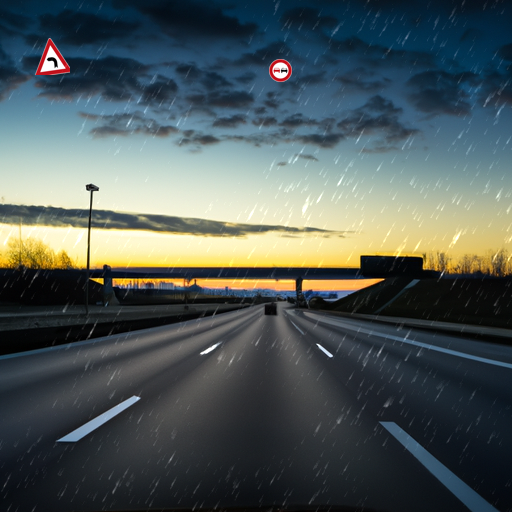

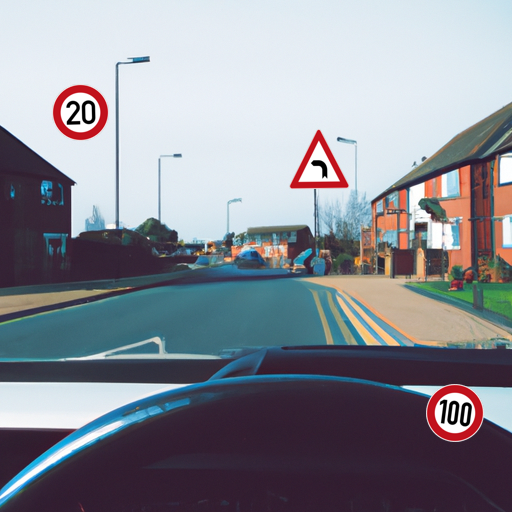

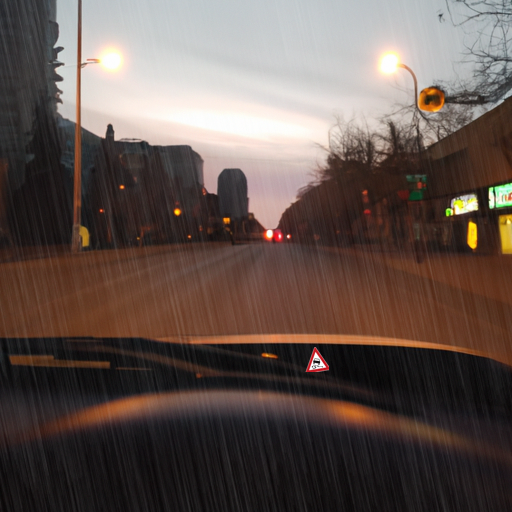

In [23]:
# display 3 random images from the training dataset
print("Random images from the training dataset:")
for i in range(3):
    random_image = random.choice(os.listdir(IMAGE_PATH))
    image = Image.open(f"{IMAGE_PATH}/{random_image}")
    display(image)

In [24]:
# Create a dictionary to store the counts for each class
class_counts = {}

# Add for each class a key to the dictionary and set the count to 0
for id, _ in enumerate(classes):
    class_counts[id] = 0

# Define dataset path
dataset_path = 'dataset'

# Define the directories to process
directories = ['train', 'valid', 'test']

# add labels to directories
for id, directory in enumerate(directories):
    directories[id] = directory + '/labels'

# Iterate over the directories
for directory in directories:
    # Check if the directory exists
    if os.path.exists(os.path.join(dataset_path, directory)):
        # Iterate over all files in the directory
        for file in os.listdir(os.path.join(dataset_path, directory)):
            # Only process .txt files
            if file.endswith('.txt'):
                # Open the file for reading
                with open(os.path.join(dataset_path, directory, file), 'r') as f:
                    # Iterate over all lines in the file
                    for line in f:
                        # Split the line into parts by whitespace
                        parts = line.split()
                        # Get the first number from the line
                        first_number = int(parts[0])
                        # Increment the count for this class in the dictionary
                        if first_number in class_counts:
                            class_counts[first_number] += 1
                        else:
                            class_counts[first_number] = 1

# Convert class ids back to class names
output_dict = {}
for key, value in class_counts.items():
    output_dict[classes[key]] = value

print(output_dict)


{'ANIMALS': 109, 'CONSTRUCTION': 112, 'CYCLES CROSSING': 131, 'DANGER': 104, 'NO ENTRY': 137, 'PEDESTRIAN CROSSING': 98, 'SCHOOL CROSSING': 120, 'SNOW': 104, 'STOP': 105, 'bend left': 127, 'bend right': 113, 'bend': 105, 'give way': 105, 'go left or straight': 91, 'go left': 123, 'go right or straight': 104, 'go right': 115, 'go straight': 119, 'keep left': 111, 'keep right': 122, 'no overtaking (trucks)': 127, 'no overtaking -trucks-': 0, 'no overtaking': 124, 'no traffic both ways': 114, 'no trucks': 124, 'priority at next intersection': 132, 'priority road': 116, 'restriction ends (overtaking (trucks))': 120, 'restriction ends (overtaking)': 0, 'restriction ends -overtaking -trucks--': 0, 'restriction ends -overtaking-': 112, 'restriction ends 80': 117, 'restriction ends': 113, 'road narrows': 104, 'roundabout': 101, 'slippery road': 103, 'speed limit 100': 121, 'speed limit 120': 106, 'speed limit 20': 110, 'speed limit 30': 108, 'speed limit 40': 120, 'speed limit 50': 127, 'speed